In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt
import matplotlib as mpl
import rich.progress


from rich.progress import (
    BarColumn,
    DownloadColumn,
    Progress,
    TaskID,
    TextColumn,
    TimeRemainingColumn,
    TaskProgressColumn,
)

# Matrix dimension 90*90*32*6*8
NImgX_ = 90
NImgY_ = 90
NDetY_ = 32
NModule_ = 6
NDetX_ = 8

In [3]:
# Open the file.
inFname = 'sysmat_8layer_Rot_0_of_1_2mmslitin10mm_1010_idxT0_numT1in1mm_IZ0_DZ0_100.sysmat'
dataSize = NImgX_*NImgY_*NDetY_*NModule_*NDetX_

with rich.progress.open('./input/{:s}'.format(inFname), 'rb') as inF:
    # Read in the matrix
    dataUnpack = np.asarray(struct.unpack('f'*dataSize, inF.read(dataSize*4)))
    # Reshape the 5D array into a 2D matrix
    dataMatrix = dataUnpack.reshape((NDetX_ * NModule_*NDetY_, NImgX_*NImgY_))
    # inF.close()

print("Complete Read-in Data!")

d:\SPEBT\.venv\lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Complete Read-in Data!


In [4]:
imgTemplate = np.zeros((NImgX_, NImgY_))
print("{:>28}:\t{:}".format("Read-in System Matrix Shape", dataMatrix.shape))

# Remove zero rows from the matrix
sysMatrix = dataMatrix[~np.all(dataMatrix == 0, axis=1)]
print("{:>28}:\t{:}".format("Reduced System Matrix Shape", sysMatrix.shape))

 Read-in System Matrix Shape:	(1536, 8100)
 Reduced System Matrix Shape:	(864, 8100)


In [6]:
# Read in the phantom
inFname = './input/circle-phantom.npz'
dataUnpack = np.load(inFname)
dataSize = NImgX_*NImgY_
phantom = dataUnpack['arr_0'].reshape((NImgX_, NImgY_))

# Calculate forward projection
projection = np.matmul(sysMatrix, phantom.flatten())
print("{:>28}:\t{:}".format("Projection Shape", projection.shape))

            Projection Shape:	(864,)


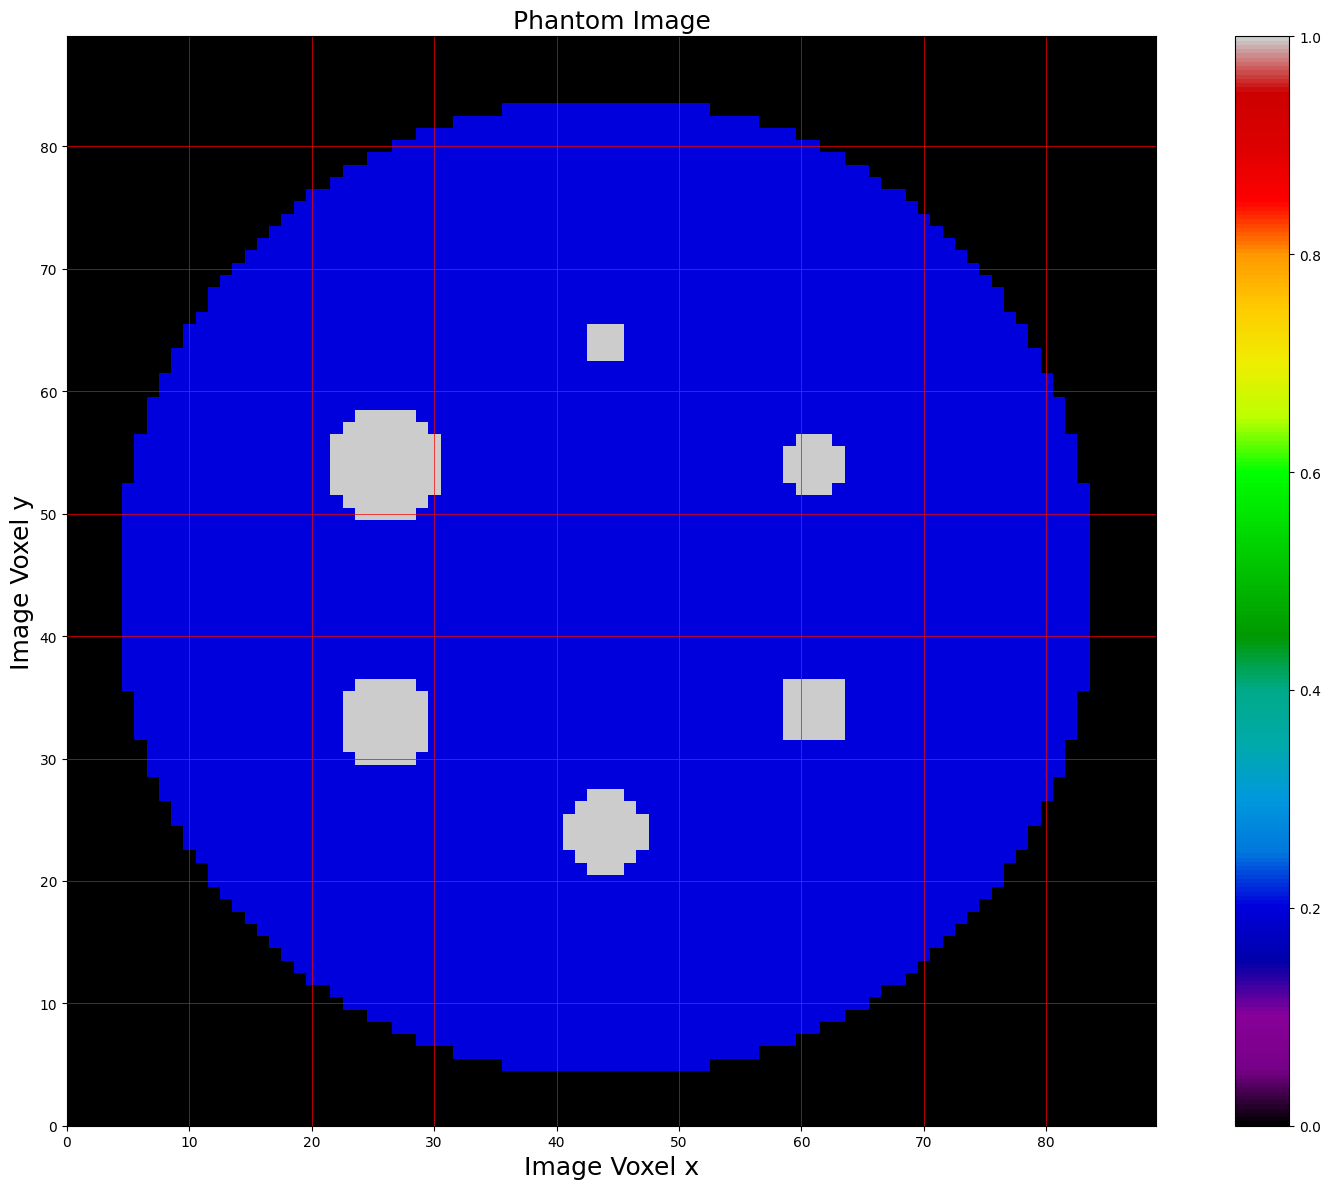

In [8]:
## Visualize the Phantom Image


# Iterate for 5000 times, start from a flat image with all ones.
NIteration = 5000
# reconImg = backwardProj(np.ones(NImgX_*NImgY_), projection, sysMatrix)
reconImg = np.ones(NImgX_*NImgY_)
# Plot the reconstructed image
plt.rcParams["figure.figsize"] = (16, 12)
fig, ax = plt.subplots()
imshow_obj = ax.imshow(phantom, cmap=plt.get_cmap('nipy_spectral'))
pltTitle = ax.set_title('Phantom Image', fontsize=18)
cbar = fig.colorbar(imshow_obj)
ax.grid(color='r', linestyle='-', linewidth=0.5)
xl = ax.set_xlabel("Image Voxel x", fontsize=18)
yl = ax.set_ylabel("Image Voxel y", fontsize=18)
ax.set_xlim(0, NImgX_-1)
ax.set_ylim(0, NImgY_-1)
imshow_obj.set_clim(0, 1)
plt.tight_layout()


In [9]:
# Implementation of the recursive Maximum-Likelihood Expectation-
# Maximization (ML-EM) algorithm.


def backwardProj(lastArr, projArr, sysMat):
    forwardLast = np.matmul(sysMat, lastArr)
    quotients = projArr/forwardLast
    return np.matmul(quotients, sysMat)/np.sum(sysMat, axis=0)*lastArr


def update(frame, myFrames, sampleRate, imshow_obj, pltTitle, cbar):
    # print("Generating Frame# {:5d}".format(frame), end='\r', flush=True)
    # print("Calculating Iteration# {:<5d}".format(frame), end='\r', flush=True)
    pltTitle.set_text(
        'Reconstructed Image Iteration#: {:>5d}'.format(int(frame/sampleRate)))
    imshow_obj.set_data(myFrames[frame])
    imshow_obj.norm.autoscale(imshow_obj._A)
    # imshow_obj.set_clim(0, 1)
    cbar.update_normal(imshow_obj.colorbar.mappable)

    return (imshow_obj, pltTitle,)

In [10]:
sampleRate_ = 0.1
totalSample = int(NIteration*sampleRate_)
myFrames = np.zeros((totalSample, NImgX_, NImgY_))


progress = Progress(
    TextColumn("[progress.description]{task.description}"),
    BarColumn(),
    # TaskProgressColumn(),
    "{task.completed}/{task.total}",
    TimeRemainingColumn(),
)


with progress:
    progress.console.print("Iterative reconstruction calculation...")
    task1 = progress.add_task("Iteration:", total=NIteration)
    for iter in range(NIteration):
        reconImg = backwardProj(reconImg, projection, sysMatrix)
        if (iter*sampleRate_).is_integer():
            myFrames[int(iter*sampleRate_)] = reconImg.reshape((NImgX_, NImgY_))
            last_idx = int(iter*sampleRate_)
        progress.advance(task1)

d:\SPEBT\.venv\lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Iterative reconstruction calculation...

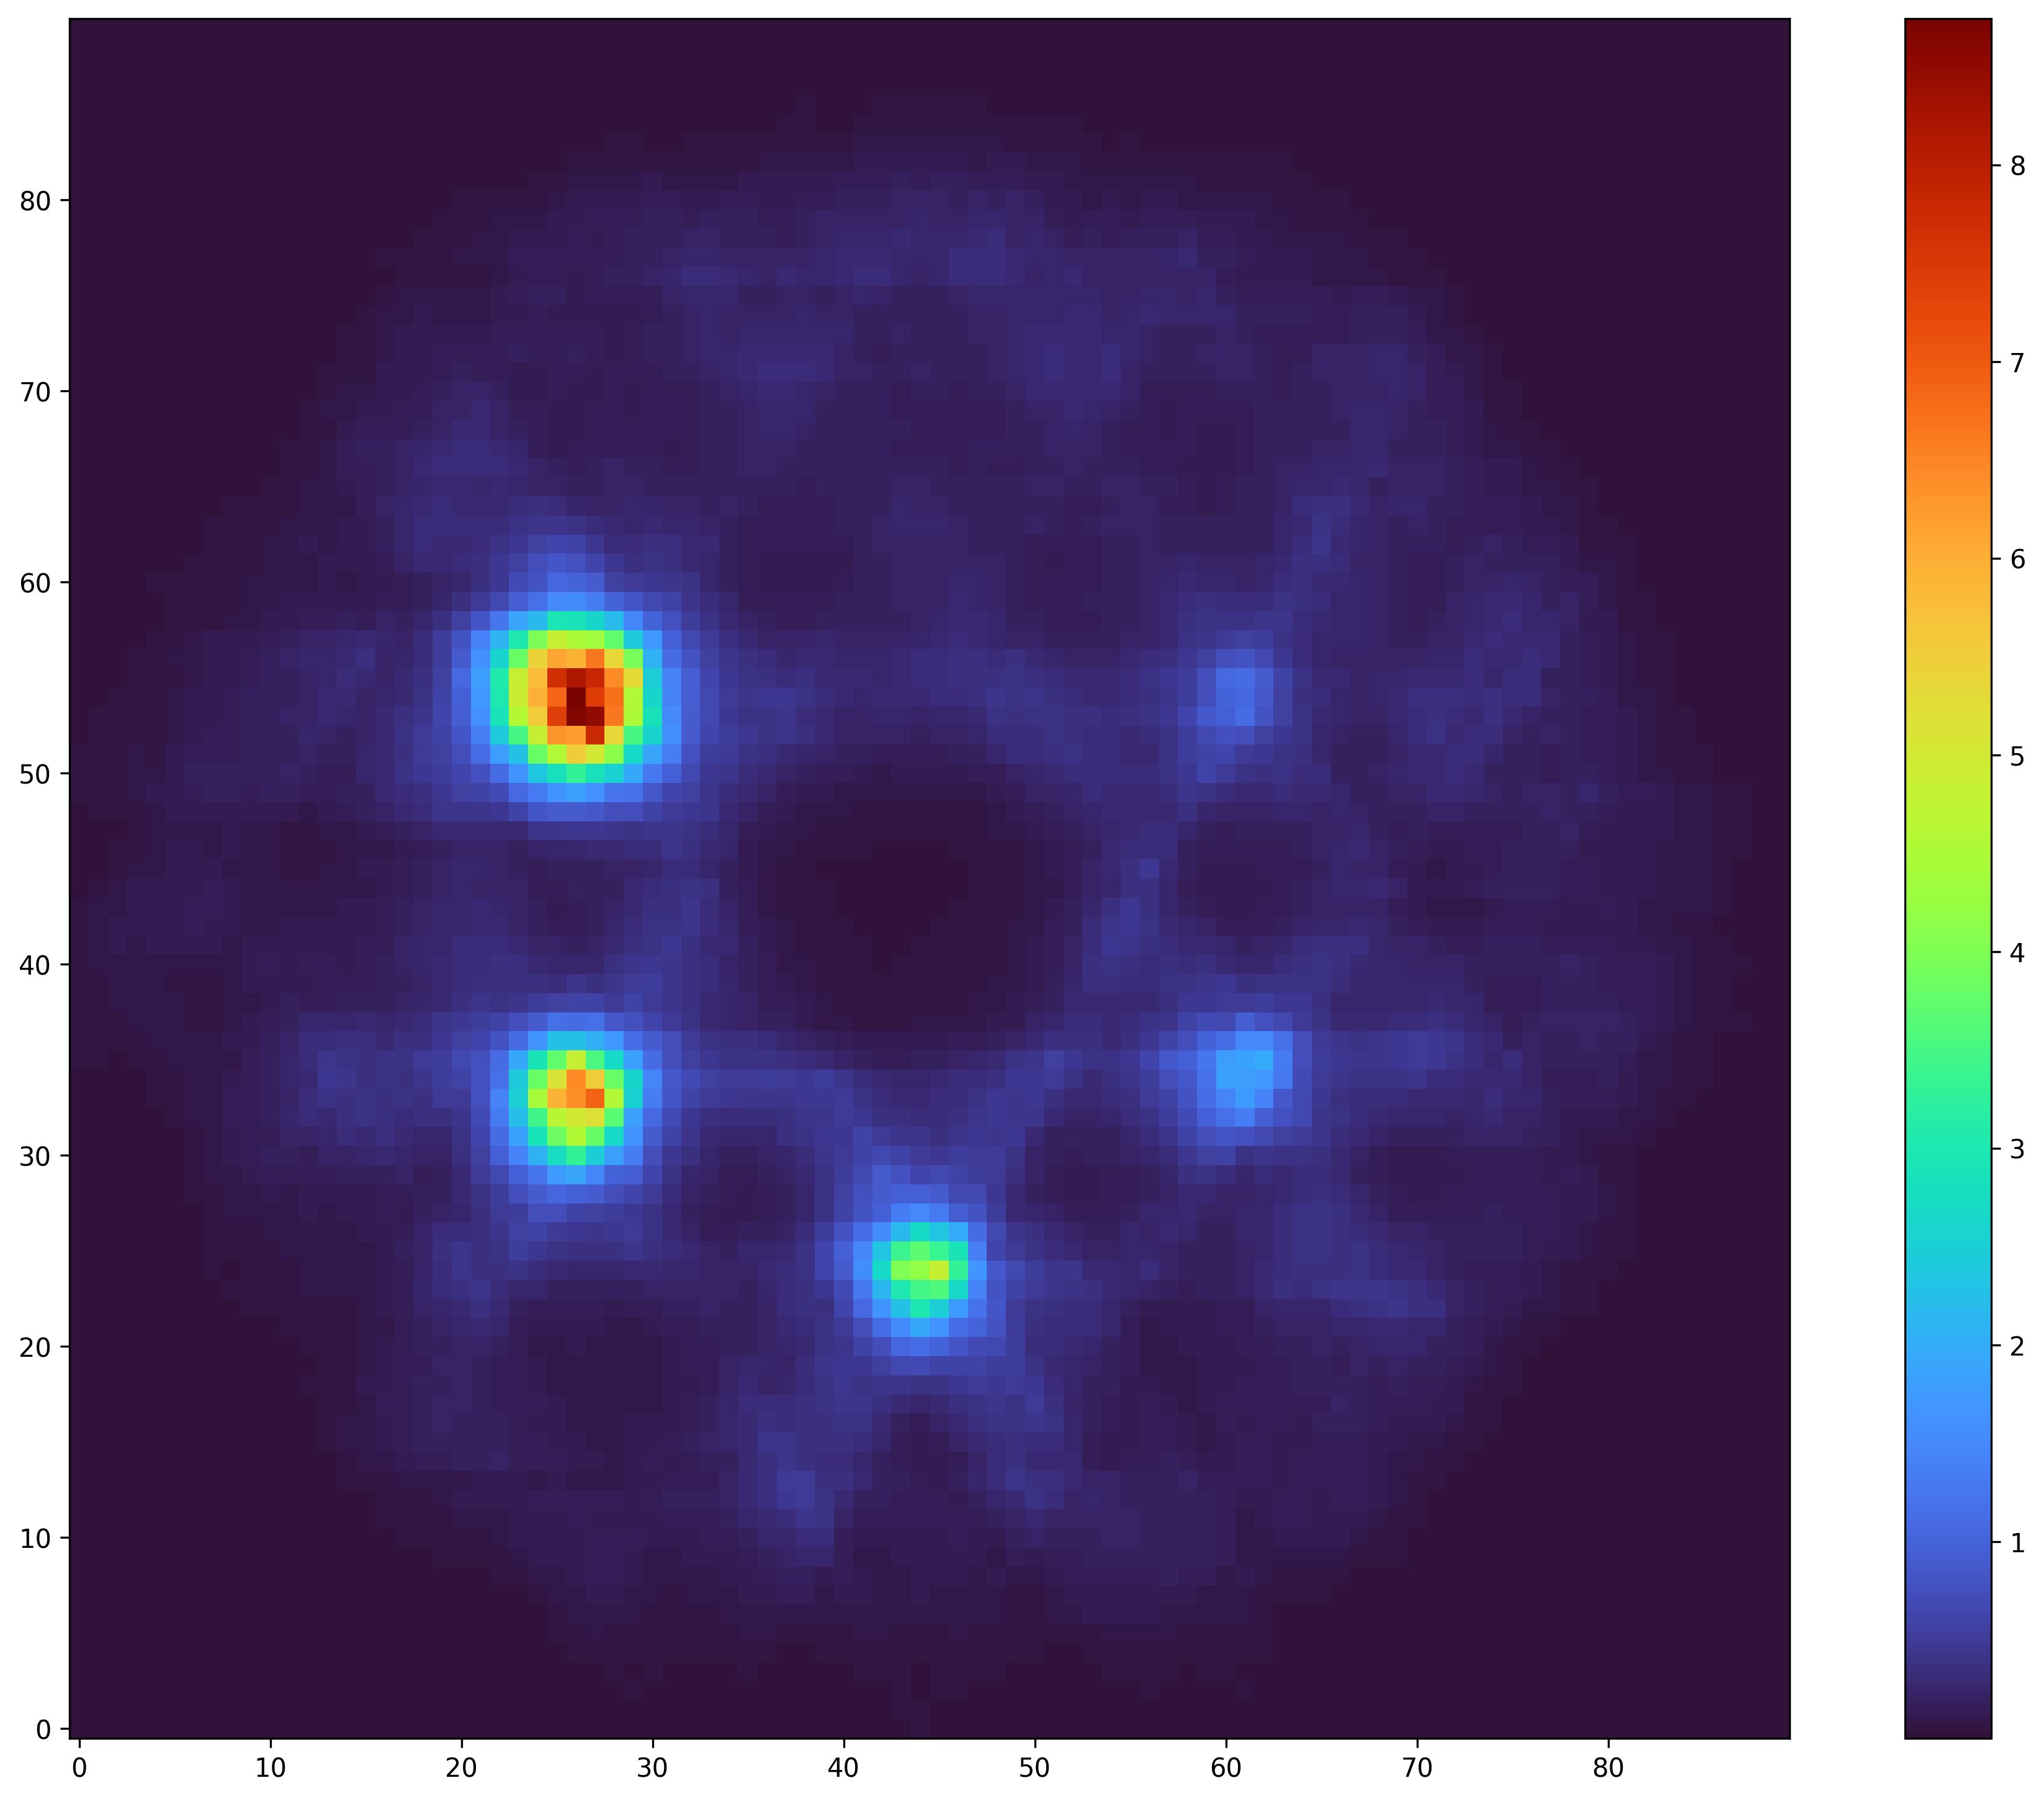

In [13]:
plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["figure.dpi"] = 300
fig, ax = plt.subplots()
imshow_obj=ax.imshow(myFrames[-1], cmap=mpl.colormaps['turbo'],origin='lower')
fig.colorbar(imshow_obj, ax=ax)